In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import scipy.stats
import sys
import pandas as pd
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf
xr.set_options(keep_attrs=True)

In [3]:
mytime = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')
mydir = '/glade/work/lettier/NUDGE/'
eddir = '/glade/scratch/wriggles/archive/'

In [4]:
def wrangle_nudge (nudge_name, myvariables):

    ds_a = xr.open_mfdataset(eddir+nudge_name+'/ice/hist/*.h.*')[myvariables]
    ds_b = xr.open_mfdataset(eddir+nudge_name+'_21C/ice/hist/*.h.*')[myvariables]
    ds = xr.concat([ds_a,ds_b],dim='time')
    ds['time'] = mytime
 
    ds['names'] = nudge_name
    ds = ds.set_coords('names')
    
    return ds

In [5]:
def wrangle_lens (e, myvariables):
    ledir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/'

    ens = str(e)
    if e<10:
        ens = '0'+str(e)
    tmp = []
    print(ens)
    for var in myvariables:
        myfiles = sorted([ledir+var+'/'+f for f in os.listdir(ledir+var) if ('B20TRC5CNBDRD' in f or 'BRCP85C5CNBDRD' in f) and '0'+ens+'.cice.h.'+var+'_nh' in f ])
        myfiles = [f for f in myfiles if '.192001-199912.nc' not in f and '208101-210012.nc' not in f]
        ds = xr.open_mfdataset(myfiles)[[var]].sel(time=slice('1979-02','2019-01'))
        ds['time'] = mytime
        tmp.append(ds)
    ds = xr.merge(tmp)
    ds['names'] = 'LENS'+ens+'_nh'
    ds = ds.set_coords('names')
      
    return ds

In [40]:
def get_spatial_stuff_aice (ds):
    da = ds['aice']
    name = str(ds.names.values)
    aice = myf.xr_reshape(da, 'time', ['year', 'month'], [np.arange(1979, 2019,1), np.arange(1,13,1)])
    aice = aice.sel(month=[3,6,9])
    clim = aice.mean(dim='year')
    slope, intercept, r_value, p_value, std_err = myf.linregress(np.arange((len(aice.year))),aice.load(),dim='year')
    
    clim = clim.to_dataset(name='aice_clim')
    slope = slope.to_dataset(name='aice_trend')
    slope.aice_trend.attrs['units'] = '%/yr'
    p_value = p_value.to_dataset(name='aice_p_value')
    p_value = 100.*p_value
    p_value.aice_p_value.attrs['units'] = '%'
    ds = xr.merge([clim, slope, p_value])
   
    ds['names'] = name
    ds = ds.set_coords('names')
    ds.attrs['desc'] = 'processed by Lettie Roach, March 2021'
    ds.to_netcdf(mydir+'processed/spatial_mean_trend/'+name+'.ice_aice_climtrend.1979-2018.nc')

    return ds


In [ ]:
for e in range(1,36,1):
    get_spatial_stuff_aice(wrangle_lens(e, ['aice']), 'aice')

In [ ]:
for run in ['anom_nudge_era_60_archi','anom_nudge_era_60_arclo','anom_nudge_era_60']:
    get_spatial_stuff_aice(wrangle_nudge(run, ['aice']), 'aice')

Observations

In [14]:
ds = xr.open_mfdataset('/glade/work/lettier/CDRv4/mon/nhdl/remap_cesmgrid/*.nc',concat_dim='tdim',combine='nested')
mytime = ds.time.values
ds = ds.drop('time')
ds['tdim'] = mytime
ds = ds.rename({'tdim':'time'})

ds = ds.sel(time=slice('1979','2018'))
ds['time'] = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')

In [25]:
obvars = ['cdr_seaice_conc_monthly','nsidc_bt_seaice_conc_monthly','nsidc_nt_seaice_conc_monthly']
mynames =['OBS-CDRv4-'+var for var in ['cdr','bt','nt']]

In [41]:
for v, var in enumerate(obvars):
    obds = ds[[var]]
    obds[var] = obds[var].where(obds[var]<=1.) # keep only valid data
    obds[var] = obds[var]*100.
    obds['names'] = mynames[v]
    obds = obds.set_coords('names')
    obds = obds.rename({var:'aice'})
    get_spatial_stuff_aice(obds)
    

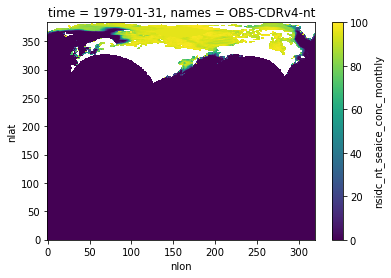

In [36]:
obds.isel(time=0)[var].plot()